In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology
from skimage.color import rgb2gray
from scipy.spatial import cKDTree



In [6]:
intersections

NameError: name 'intersections' is not defined

In [8]:
threshold


NameError: name 'threshold' is not defined

In [10]:
np.mean(img)

NameError: name 'img' is not defined

Version 2 with global CTRL thresh

Skeleton version

Version 4 with all line lengths reported (for histograms, SD etc)

WIP : Reporting full list of segment lengths... currently as separate file

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology
from skimage.color import rgb2gray
from scipy.spatial import cKDTree
import os
import pandas as pd



def load_image(image_path):
    img = io.imread(image_path)
    if len(img.shape) == 3:  # Convert to grayscale if RGB
        img = rgb2gray(img)
    return img

def compute_control_threshold(control_folder):
    control_images = [load_image(os.path.join(control_folder, f)) for f in os.listdir(control_folder) if f.endswith(".tif")]
    control_means = [np.mean(filters.gaussian(img, sigma=1)) for img in control_images]
    control_stds = [np.std(filters.gaussian(img, sigma=1)) for img in control_images]
    global_threshold = np.mean(control_means) + np.mean(control_stds) * 0.5
    return global_threshold

def preprocess_image(img, global_threshold, sigma=2, size_threshold=50):
    blurred = filters.gaussian(img, sigma=sigma)
    binary = blurred > global_threshold
    
    # Remove small particles
    labeled = measure.label(binary)
    regions = measure.regionprops(labeled)
    filtered = np.zeros_like(binary)
    
    for region in regions:
        if region.area > size_threshold:
            for coord in region.coords:
                filtered[coord[0], coord[1]] = 1
    
    return filtered

def generate_grid(img_shape, nx=80, ny=80):
    x_seq = np.linspace(0, img_shape[1] - 1, nx)
    y_seq = np.linspace(0, img_shape[0] - 1, ny)
    
    vertical_lines = [(int(x), 0, int(x), img_shape[0] - 1) for x in x_seq]
    horizontal_lines = [(0, int(y), img_shape[1] - 1, int(y)) for y in y_seq]
    
    return vertical_lines + horizontal_lines

def calculate_uninterrupted_lengths(binary_img, grid_lines):
    points = np.column_stack(np.where(binary_img > 0))
    tree = cKDTree(points)
    
    segment_data = []
    segments = []
    for x1, y1, x2, y2 in grid_lines:
        line_x = np.linspace(x1, x2, num=2018, dtype=int)
        line_y = np.linspace(y1, y2, num=2018, dtype=int)
        line_points = np.column_stack((line_y, line_x))

        current_length = 0
        color_toggle = False
        current_segment = []

        for point in line_points:
            distance, _ = tree.query(point, distance_upper_bound=1)
            if distance < 1:
                if current_length > 0:
                    segment_data.append((current_length, color_toggle))
                    segments.append((np.array(current_segment), color_toggle))
                    current_segment = []
                    current_length = 0
                    color_toggle = not color_toggle
            else:
                current_length += 1
                current_segment.append(point)

        if current_length > 0:
            segment_data.append((current_length, color_toggle))
            segments.append((np.array(current_segment), color_toggle))

    return segment_data, segments


In [14]:


#control_folder = "C:/Users/decae/Python Scripts\Python TJ Analysis/ExampleData/250729-Opto - StargaziniLID + SspB RhoGEF_HIGH - Zo1mSG KOPals1 2day Opto OVERNIGHT/250729-Opto Zo1-mSG Tiffs/CTRL"
#global_threshold = compute_control_threshold(control_folder)

#image_folder = "C:/Users/decae/Python Scripts\Python TJ Analysis/ExampleData/250729-Opto - StargaziniLID + SspB RhoGEF_HIGH - Zo1mSG KOPals1 2day Opto OVERNIGHT/250729-Opto Zo1-mSG Tiffs"
#output_folder = "C:/Users/decae/Python Scripts\Python TJ Analysis/ExampleData/250729-Opto - StargaziniLID + SspB RhoGEF_HIGH - Zo1mSG KOPals1 2day Opto OVERNIGHT/250729-Opto Zo1-mSG Tiffs/Output"
#os.makedirs(output_folder, exist_ok=True)


control_folder = "/Users/apple/Desktop/Ian_lab/data/CTRL"
global_threshold = compute_control_threshold(control_folder)

image_folder = "/Users/apple/Desktop/Ian_lab/data/TJlength_analysis"
output_folder = "/Users/apple/Desktop/Ian_lab/data/TJlength_analysis/Output"
os.makedirs(output_folder, exist_ok=True)


segment_results = []

for filename in os.listdir(image_folder):
    if filename.endswith(".tif"):
        image_path = os.path.join(image_folder, filename)
        img = load_image(image_path)
        binary_img = morphology.thin(preprocess_image(img, global_threshold))
        grid_lines = generate_grid(img.shape)

        # Compute uninterrupted segment lengths
        segment_data, segments = calculate_uninterrupted_lengths(binary_img, grid_lines)
        avg_segment_length = np.mean([s[0] for s in segment_data]) if segment_data else 0

        for idx, (length, _) in enumerate(segment_data):
            segment_results.append({"Filename": filename, "Segment_ID": idx, "Segment_Length": length})

        # Save plot
        fig, ax = plt.subplots(1, 2, figsize=(24, 12))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].imshow(binary_img, cmap='gray')
        ax[1].set_title("Processed Binary Image")

        for (x1, y1, x2, y2) in grid_lines:
            ax[1].plot([x1, x2], [y1, y2], color='lime', linewidth=0.5)
        
        # Plot alternating segment colors
        for segment, color_toggle in segments:
            if len(segment) > 0:
                segment = np.array(segment)
                ax[1].plot(segment[:, 1], segment[:, 0], color='yellow' if color_toggle else 'blue', linewidth=1)
        
        #ax[2].hist([s[0] for s in segment_data], bins=20, color='gray', edgecolor='black')
        #ax[2].set_title("Segment Length Histogram")
        #ax[2].set_xlabel("Segment Length")
        #ax[2].set_ylabel("Frequency")
        
        plt.savefig(os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_analysis.png"))
        plt.close()

# Save segment lengths to CSV
segment_df = pd.DataFrame(segment_results)
segment_df.to_csv(os.path.join(output_folder, "segment_lengths.csv"), index=False)

Average segment lengths (per frame) saved to /Users/apple/Desktop/Ian_lab/data/TJlength_analysis/Output/average_segment_lengths_by_frame.csv


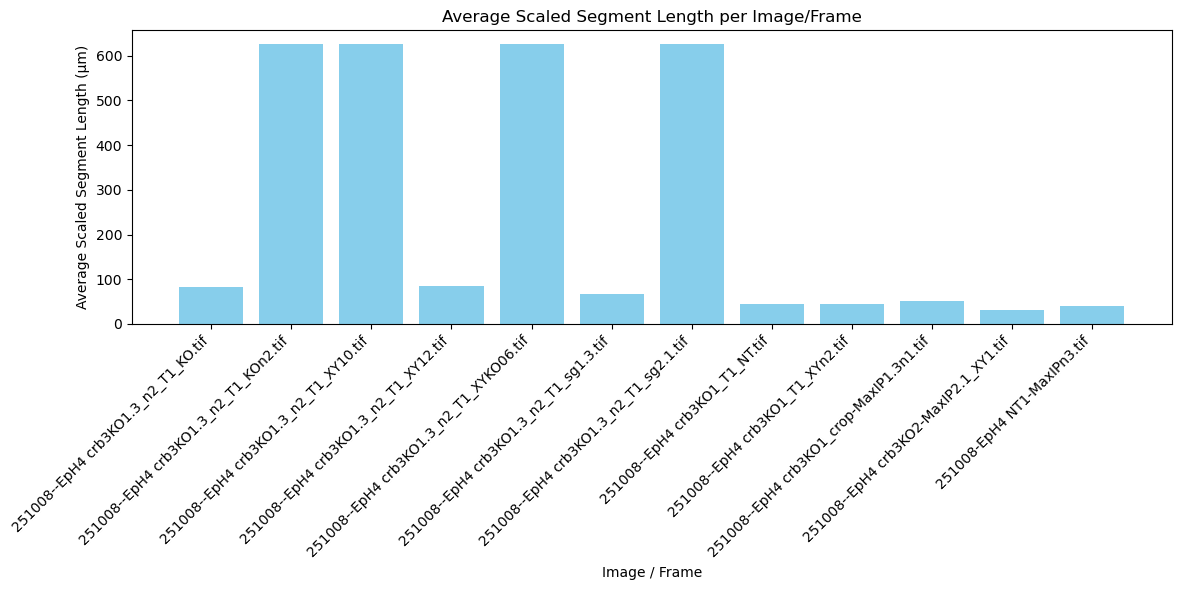

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the segment lengths data
segment_lengths_path = "/Users/apple/Desktop/Ian_lab/data/TJlength_analysis/Output/segment_lengths.csv"
segment_df = pd.read_csv(segment_lengths_path)

# Define pixel sizes for different magnifications
pixel_sizes = {
    "40x_1x": 0.31,  # 0.31 µm/pixel for 40x 1x Zoom
    "40x_2x": 0.16   # 0.16 µm/pixel for 40x 2x Zoom
}

# Add a column for scaled segment lengths
zoom_level = "40x_1x"  # Change this based on your image settings
pixel_size = pixel_sizes[zoom_level]
segment_df["Scaled_Segment_Length"] = segment_df["Segment_Length"] * pixel_size

# Aggregate by filename and frame (if present)
if "Frame" in segment_df.columns:
    group_cols = ["Filename", "Frame"]
else:
    group_cols = ["Filename"]

summary_df = segment_df.groupby(group_cols).agg(
    Average_Scaled_Length=("Scaled_Segment_Length", "mean"),
    Median_Scaled_Length=("Scaled_Segment_Length", "median"),
    Segment_Count=("Scaled_Segment_Length", "count")
).reset_index()

# Save the detailed summary
output_base = "/Users/apple/Desktop/Ian_lab/data/TJlength_analysis/Output"
by_frame_path = f"{output_base}/average_segment_lengths_by_frame.csv"
summary_df.to_csv(by_frame_path, index=False)
print(f"Average segment lengths (per frame) saved to {by_frame_path}")

# Optional: aggregate across frames for per-file overview
if "Frame" in segment_df.columns:
    file_summary_df = segment_df.groupby("Filename").agg(
        Average_Scaled_Length=("Scaled_Segment_Length", "mean"),
        Median_Scaled_Length=("Scaled_Segment_Length", "median"),
        Segment_Count=("Scaled_Segment_Length", "count")
    ).reset_index()
    by_file_path = f"{output_base}/average_segment_lengths_by_file.csv"
    file_summary_df.to_csv(by_file_path, index=False)
    print(f"Average segment lengths (per file) saved to {by_file_path}")
else:
    file_summary_df = summary_df.copy()

# Prepare labels for plotting
if "Frame" in summary_df.columns:
    summary_df["Label"] = summary_df.apply(lambda row: f"{row['Filename']} (F{int(row['Frame'])})", axis=1)
else:
    summary_df["Label"] = summary_df["Filename"]

# Plot the average scaled segment lengths into a bar graph
plt.figure(figsize=(12, 6))
plt.bar(summary_df["Label"], summary_df["Average_Scaled_Length"], color="skyblue")
plt.xlabel("Image / Frame")
plt.ylabel("Average Scaled Segment Length (µm)")
plt.title("Average Scaled Segment Length per Image/Frame")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
